# Save the NLIW depression flux calculations


In [1]:
import os
import numpy as np
import xarray as xr
from d2spike.utils import nan_gauss_xr
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from chp3_basefuncs import *
from chp3_fluxfuncs import *

## Loop through and load the events

In [2]:
moor_file = 'T150'
field_trip = 'RS2019'
wave_type = 'NLIW'

# Set constants
# varname = 'Temperature'
depthvar = 'z_nom'

# Set key data directories and outputs
project_root = r'/mnt/c/Users/00099894/Large_Data/'
work_dir = r'/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/PhD/pl'
load_dir = os.path.join(project_root, field_trip, wave_type)

In [3]:
# Load temp data
fieldtrip = 'RS2019'
temp_file = 'RowleyShoals_Gridded_Mooring_T_SBE56.nc'
temp_nc = os.path.join(project_root, fieldtrip, temp_file)
ds_temp = xr.open_dataset(temp_nc, group=moor_file)
ds_temp.close()

In [4]:
wav_tx = get_nliw_times()

# Set some params
thin_v = 2
thin_h = 2*5

# filter params
filt_z = 4
filt_x = 300

### Loop through events and save

Nearfield correction applied to cells within 0.63 m
Nearfield correction applied to cells within 0.63 m
Nearfield correction applied to cells within 0.63 m
Nearfield correction applied to cells within 0.63 m
Nearfield correction applied to cells within 0.63 m
Nearfield correction applied to cells within 0.63 m
Nearfield correction applied to cells within 0.63 m
Nearfield correction applied to cells within 0.63 m
Nearfield correction applied to cells within 0.63 m
Nearfield correction applied to cells within 0.63 m
Nearfield correction applied to cells within 0.63 m


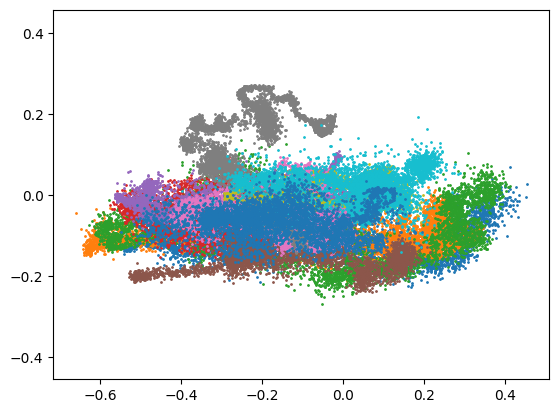

In [5]:
# Loop thorugh files
for ii, wt in enumerate(wav_tx):

    # if ii != 2:

        # Load currents
        sig_fil = f'{wave_type}_{int(ii+1)}_ENU.nc'
        vel_file = os.path.join(load_dir, sig_fil)
        ds = xr.open_dataset(vel_file)
        xr.Dataset.close(ds)
        hx = np.arange(len(ds.height.values.copy())-3)
        ds_adj = ds.isel(height=hx)

        # Load echo
        sig_fil = f'{wave_type}_{int(ii+1)}_echo.nc'
        vel_file = os.path.join(load_dir, sig_fil)
        ee = xr.open_dataset(vel_file)
        xr.Dataset.close(ee)    
        echo = ee.isel(height=hx)
        echo = echo.rename({'__xarray_dataarray_variable__':'echo'})
        echo = echo['echo']

        # Get temp data
        temp_ix = (ds_temp['time'].values >= ds_adj.time.values[0]) &\
                (ds_temp['time'].values <= ds_adj.time.values[-1])

        # Rotate the data
        (u_turb, v_turb), theta_sig = rotate_data(ds_adj)
        plt.scatter(u_turb[150,::10], v_turb[150,::10], s=1)
        plt.axis('equal')

        # Use 2D GF instead of rolling
        u_mean, u_turb = reynolds_decomp(u_turb, [filt_z,filt_x])
        u_mean = u_mean[::thin_v, ::thin_h]
        v_mean, v_turb = reynolds_decomp(v_turb, [filt_z,filt_x])
        v_mean = v_mean[::thin_v, ::thin_h]

        w_mean, _ = reynolds_decomp(ds_adj['enu'].isel(cartesian_axes=2), [filt_z,filt_x])
        w_mean = w_mean[::thin_v, ::thin_h]
        _, w_turb = reynolds_decomp(ds_adj['beam5'], [filt_z,filt_x])

        ssc, beam_corrected = load_c(echo.squeeze(), ds_temp, work_dir, fieldtrip, bs_corrected=True)
        ssc = ssc.T
        c_mean, c_turb = reynolds_decomp(ssc, [filt_z,filt_x])
        c_mean = c_mean[::thin_v, ::thin_h]

        # Calculate the Reynolds flux
        wc_turb_raw = w_turb * c_turb
        wc_turb = nan_gauss_xr(wc_turb_raw, [filt_z,filt_x])
        wc_turb = wc_turb[::thin_v, ::thin_h]

        # Calculate the vertical TKE
        w2_turb = w_turb**2
        w2_turb = nan_gauss_xr(w2_turb, [filt_z,filt_x])
        w2_turb = w2_turb[::thin_v, ::thin_h]

        beam_xr = xr.DataArray(beam_corrected, dims=['time', 'height']).T[::thin_v, ::thin_h]
        ds_new = xr.Dataset({'w2_turb': w2_turb, 'wc_turb': wc_turb, 'u_mean': u_mean, 'v_mean': v_mean, 
                             'w_mean': w_mean, 'c_mean': c_mean, 'echo_corrected': beam_xr})

        # Add the rotation as an attribute
        ds_new.attrs['sig_direction'] = theta_sig

        # ds_new['s'] = xr.DataArray([s1, s2, s3], dims='s')
        save_path = os.path.join(load_dir, f'{wave_type}_E{int(ii+1)}_flux.nc')
        ds_new.to_netcdf(save_path)